In [2]:
import pandas as pd
import numpy as np
#import pandas_profiling
import math, os
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
import statsmodels.tsa.stattools as ts
#import cufflinks as cf
from pandas.plotting import autocorrelation_plot
#from pyramid.arima import auto_arima
import matplotlib.pyplot as plt
%matplotlib notebook
"""from pylab import rcParams
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
#import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
import plotly
import statsmodels.api as sm
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls

# Authenticate with your account
plotly.tools.set_credentials_file(username='jonikorp',                                              
                                  api_key='5tNKNgdlXFMySfutyaPV') 
"""

"from pylab import rcParams\nmatplotlib.rcParams['axes.labelsize'] = 14\nmatplotlib.rcParams['xtick.labelsize'] = 12\nmatplotlib.rcParams['ytick.labelsize'] = 12\nmatplotlib.rcParams['text.color'] = 'k'\n#import matplotlib.pyplot as plt\n\nplt.style.use('fivethirtyeight')\nimport plotly\nimport statsmodels.api as sm\nimport plotly.plotly as py\nimport plotly.graph_objs as go\nimport plotly.tools as tls\n\n# Authenticate with your account\nplotly.tools.set_credentials_file(username='jonikorp',                                              \n                                  api_key='5tNKNgdlXFMySfutyaPV') \n"

In [14]:
def load_hourly_fi_data():
    dataframes = []
    rel_path = "data/elspot/"
    for excel in sorted(os.listdir(rel_path)):
        df = pd.read_excel(rel_path+excel,header=2,decimal=",",dtype={'FI': np.float64})
        dataframes.append(df)
    #dataframes.pop()
    elspot_df = pd.concat(dataframes, ignore_index=True)
    #fi_df = pd.DataFrame(pd.date_range(start='01/01/2013', end='01/01/2019',freq='H', tz='Europe/Berlin'), columns=['Date'])
    fi_df = pd.DataFrame(pd.date_range(start='01/01/2013', end='29/01/2019',freq='H', tz='Europe/Berlin'), columns=['Date'])
    fi_df = fi_df[:-1] # poista turha 01/01/2019 date
    fi_df[['FI']] = elspot_df[['FI']]
    fi_df.set_index('Date',inplace=True)
    fi_df.fillna(method="bfill",inplace=True)
    return fi_df
    
def load_daily_fi_data():
    dataframes = []
    rel_path = "data/elspot_daily/"
    for excel in sorted(os.listdir(rel_path)):
        df = pd.read_excel(rel_path+excel,header=2,decimal=",",dtype={'FI': np.float64})
        dataframes.append(df)
    elspot_df = pd.concat(dataframes,ignore_index=True)
    fi_df = pd.DataFrame(pd.date_range(start='01/01/2013', end='01/01/2019',freq='D'), columns=['Date'])
    fi_df[['FI']] = elspot_df[['FI']]
    fi_df.set_index('Date',inplace=True)
    fi_df.fillna(method="bfill",inplace=True)
    fi_df = fi_df[:-1] # poista turha 01/01/2019 date
    return fi_df

# Nordic Electricity Generation
Below is a visulation of how much Nordic countries consume energy and what are the different types that the energy is generated with. Data is from European Network of Transmission System Operators for Electricitys Statistical Factsheet 2017.

<IPython.core.display.Javascript object>


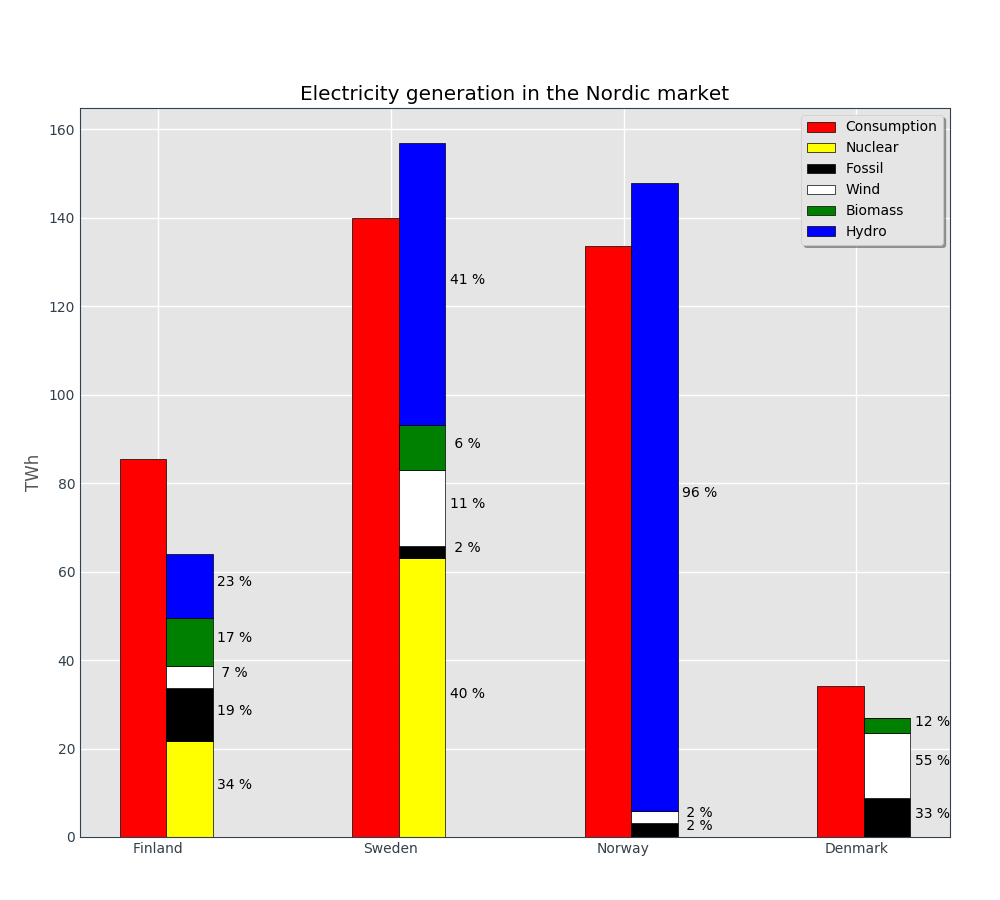

In [17]:
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams["figure.figsize"] = (10,9)

df = pd.DataFrame(index=['Finland','Sweden','Norway','Denmark'],columns=['Consumption','Nuclear','Fossil','Wind','Biomass','Hydro'])
#countries = ('Finland','Sweden','Norway','Denmark')
consumption = (85.5,139.9,133.7,34.1)
nuclear = (21.6,63.0,0,0)
fossil = (12.2,2.7,3.1,8.8)
wind = (4.8,17.3,2.7,14.8)
biomass = (10.9,10.1,0,3.2)
hydro = (14.6,63.9,142.1,0)
generation = (65.1,159.1,148.6,29.4)
for col, data in ('Consumption',consumption),('Nuclear',nuclear),('Fossil',fossil),('Wind',wind),('Biomass',biomass),('Hydro',hydro):
    df[col] = data
fig, ax = plt.subplots()  
ind = np.arange(4)    # the x locations for the groups
width = 0.20         # the width of the bars
p1 = ax.bar(ind, consumption, width, color='r', bottom=0,edgecolor='black')
p3 = ax.bar(ind + width, nuclear, width, color='yellow', bottom=0,edgecolor='black')
p4 = ax.bar(ind + width, fossil, width, color='black', bottom=nuclear,edgecolor='black')
p5 = ax.bar(ind + width, wind, width, color='white', bottom=np.array(fossil)+np.array(nuclear),edgecolor='black')
p6 = ax.bar(ind + width, biomass, width, color='green', bottom=np.array(wind)+np.array(fossil)+np.array(nuclear),edgecolor='black')
p7 = ax.bar(ind + width, hydro, width, color='blue', bottom=np.array(biomass)+np.array(wind)+np.array(fossil)+np.array(nuclear),edgecolor='black')
for country,x in zip(df.index,range(0,5)):
    if df['Nuclear'].loc[country] != 0: ax.text(x=ind[x]+width+0.12,y=nuclear[x]/2,s=f"{(df['Nuclear'].loc[country] / df.loc[country].values[1:].sum())*100:2.0f} %")
    if df['Fossil'].loc[country] != 0: ax.text(x=ind[x]+width+0.12,y=nuclear[x] + fossil[x]/2,s=f"{(df['Fossil'].loc[country] / df.loc[country].values[1:].sum())*100:2.0f} %")
    if df['Wind'].loc[country] != 0: ax.text(x=ind[x]+width+0.12,y=nuclear[x] + fossil[x] + wind[x]/2,s=f"{(df['Wind'].loc[country] / df.loc[country].values[1:].sum())*100:2.0f} %")
    if df['Biomass'].loc[country] != 0: ax.text(x=ind[x]+width+0.12,y=nuclear[x] + fossil[x] + wind[x] + biomass[x]/2,s=f"{(df['Biomass'].loc[country] / df.loc[country].values[1:].sum())*100:2.0f} %")
    if df['Hydro'].loc[country] != 0: ax.text(x=ind[x]+width+0.12,y=nuclear[x] + fossil[x] + wind[x] + biomass[x] + hydro[x]/2,s=f"{(df['Hydro'].loc[country] / df.loc[country].values[1:].sum())*100:2.0f} %")

ax.set_title('Electricity generation in the Nordic market')
ax.set_xticks(ind + width / 3)
ax.set_ylabel('TWh')
ax.set_xticklabels(('Finland', 'Sweden', 'Norway', 'Denmark'))
ax.legend((p1[0], p3[0], p4[0], p5[0], p6[0], p7[0]), ('Consumption', 'Nuclear','Fossil','Wind','Biomass','Hydro'),loc=1,shadow=True)
#ax.autoscale_view()
plt.show()

In [15]:
#fi_df = load_daily_fi_data()
fi_df = load_hourly_fi_data()
# SPOT vuoden tuntihinnat DataFrameen
# aikaleimat puuttuvista arvoista -> #fi_df[fi_df['FI'].isnull()].index.tolist()
# timezone CEST

#elspot_df = pd.read_excel("data/elspot/elspot-prices_2018_hourly_eur.xlsx",header=2, decimal=",",dtype={'FI': np.float64})
#df2 = pd.read_excel("data/elspot-prices_2017_hourly_eur.xlsx",header=2, decimal=",",dtype={'FI': np.float64})
#series = pd.Series(elspot_df.loc[:,'FI'],dtype=np.float64)
#fi_df.insert(1,"FI",series)

/home/joni/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [18]:
fi_df.index = fi_df.index.tz_convert('Europe/Helsinki')
#df = timeshift_df['2018-01-01':'2018-01-10']
df = fi_df['2018-01-01':'2018-01-10']
decomposition = sm.tsa.seasonal_decompose(df, freq=24, model='additive')
decomp_data = go.Scatter(x=decomposition.seasonal.index,
                         y=decomposition.seasonal.values)
fig = go.Figure(data=[decomp_data])
py.iplot(fig)

/home/joni/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [26]:
df = fi_df['2013-01-01':'2018-12-31']
#market_data = go.Scatter(x=testi.index,
#                         y=testi.values)
layout = go.Layout(title='Power market spot price trend between 2013 and 2018', xaxis=dict(title='Date'),
                   yaxis=dict(title='Trend'))
#fig = go.Figure(data=[market_data], layout=layout)
#py.iplot(fig)
#rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(df, freq=720, model='additive')
decomp_data = go.Scatter(x=decomposition.trend.index,
                         y=decomposition.trend.values)
fig = go.Figure(data=[decomp_data],layout=layout)
py.iplot(fig)
#py.iplot()
#decomposition.plot()
#fig = decomposition.plot()
#plt.show()

/home/joni/.local/lib/python3.6/site-packages/plotly/plotly/plotly.py:230: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.

/home/joni/.local/lib/python3.6/site-packages/plotly/plotly/plotly.py:230: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some

The draw time for this plot will be slow for clients without much RAM.


/home/joni/.local/lib/python3.6/site-packages/plotly/api/v1/clientresp.py:40: UserWarning:

Estimated Draw Time Slow



In [27]:
df = fi_df['2018-01-01':'2018-12-31']

layout = go.Layout(title='Power market spot price trend in 2018', xaxis=dict(title='Date'),
                   yaxis=dict(title='Trend'))

decomposition = sm.tsa.seasonal_decompose(df, freq=24, model='additive')
decomp_data = go.Scatter(x=decomposition.trend.index,
                         y=decomposition.trend.values)
fig = go.Figure(data=[decomp_data],layout=layout)
py.iplot(fig)

In [30]:
df = fi_df['2013-01-01':'2018-12-31']
layout = go.Layout(title='Power market spot price residual in 2018', xaxis=dict(title='Date'),
                   yaxis=dict(title='Trend'))

decomposition = sm.tsa.seasonal_decompose(df, freq=24, model='additive')
decomp_data = go.Scatter(x=decomposition.resid.index,
                         y=decomposition.resid.values)
fig = go.Figure(data=[decomp_data],layout=layout)
py.iplot(fig)

/home/joni/.local/lib/python3.6/site-packages/plotly/plotly/plotly.py:230: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.

/home/joni/.local/lib/python3.6/site-packages/plotly/plotly/plotly.py:230: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some

The draw time for this plot will be slow for clients without much RAM.


/home/joni/.local/lib/python3.6/site-packages/plotly/api/v1/clientresp.py:40: UserWarning:

Estimated Draw Time Slow



In [5]:
data_df = pd.read_excel("data/lampotila/helsinki_vantaa_2018_lampotila_tunneittain.xlsx",sheet_name="Havainnot")
lampotila_df = pd.DataFrame(pd.date_range(start="01/01/2018 00:00",end="01/01/2019 00:00",freq='H'),columns=['Date'])
lampotila_df['Temperature'] = data_df['Ilman lämpötila (degC)']
lampotila_df.set_index('Date',inplace=True)
lampotila_df.fillna(method="bfill",inplace=True)

In [6]:
testi = lampotila_df['2018-01-01':'2018-12-31']
lampotila_data = go.Scatter(x=testi.index,
                         y=testi.values)
layout = go.Layout(title='Lämpötila Helsinki-Vantaan lentokentällä 2018', xaxis=dict(title='Date'),
                   yaxis=dict(title='Celsius'))
fig = go.Figure(data=[lampotila_data], layout=layout)
py.iplot(fig)

# Predicting outliers
How to predict sudden spikes in spot price. Maybe look at outliers in temperatures or consumption

In [103]:
from sklearn import preprocessing
from statsmodels.tsa.seasonal import seasonal_decompose

# residual out of temp to figure out peaks
df = pd.read_pickle('combined_df_engineered_T-24.pickle')
decompose = seasonal_decompose(df['Finland Temperature'],freq=24,model='additive')
dec_resid_df = pd.DataFrame(data=decompose.resid.values,index=decompose.resid.index)

decompose_cons = seasonal_decompose(df['Consumption'],freq=24,model='additive')
cons_resid_df = pd.DataFrame(data=decompose_cons.resid.values,index=decompose_cons.resid.index)

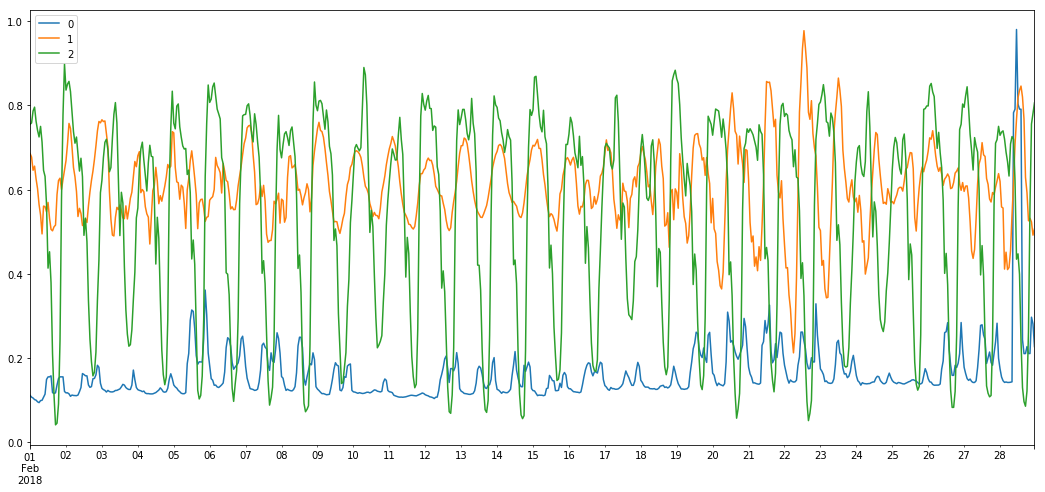

In [104]:
#df['Finland Temperature']['2018'].plot(figsize=(16,6))
#scaled_values = preprocessing.MinMaxScaler().fit_transform(df[['Spot','Consumption']]['2018'])
temp_df = pd.DataFrame(index=df.index)
temp_df['Spot'] = df['Spot']
temp_df['Finland Temperature Residual'] = dec_resid_df[0]
temp_df['Consumption Residual'] = cons_resid_df[0]
scaled_values = preprocessing.MinMaxScaler().fit_transform(temp_df[['Spot','Finland Temperature Residual','Consumption Residual']]['2018'])
norm_df = pd.DataFrame(data=scaled_values,index=df['2018'].index)
norm_df['2018-02'].plot(figsize=(18,8))

In [113]:
temp_df.to_pickle('two_features_df.pickle')

# Stationarity Test

Dickey-Fuller test for the years 2013-2018. The ADF test statistic is smaller than the 1% critical value and our p-value is lower than 0.05. This means that it's likely that we can reject the null hypothesis (= time series has a unit root, some time dependent structure) and support the alternate hypothesis, which means that the time series does not have a unit root and is stationary.

In [91]:
def adfuller_results(y):
    result = adfuller(y)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}" )
    print(f"Lag: {result[2]}")
    print(f"Observations: {result[3]}")
    print('Critical Values:')
    for key, value in result[4].items():
        print(f"\t: {key, value}")

In [92]:
df = fi_df['2013-01-01' : '2018-12-31']
adfuller_results(df['FI'].values)

ADF Statistic: -15.659413824777594
p-value: 1.5607060313615175e-28
Lag: 58
Observations: 52525
Critical Values:
	: ('1%', -3.430474504895001)
	: ('5%', -2.861595028664898)
	: ('10%', -2.5667992899282113)


The same Dickey-Fuller test applied only to January 2018 hourly time series. This time the ADF statistic is a little bit larger than the 1% critical value. 

In [93]:
df = fi_df['2018-01-01' : '2018-02-01']
adfuller_results(df['FI'].values)

ADF Statistic: -3.4932514902086447
p-value: 0.00816211102773799
Lag: 20
Observations: 747
Critical Values:
	: ('1%', -3.439134355513998)
	: ('5%', -2.865416893922985)
	: ('10%', -2.56883447171999)


If we log transform the observed values, the ADF Statistic is still larger than the 1% critical value, which means that we can fail the null hypothesis on a monthly level

In [94]:
df = fi_df['2018-01-01' : '2018-02-01']
adfuller_results(df['FI'].values)

ADF Statistic: -3.4932514902086447
p-value: 0.00816211102773799
Lag: 20
Observations: 747
Critical Values:
	: ('1%', -3.439134355513998)
	: ('5%', -2.865416893922985)
	: ('10%', -2.56883447171999)


On a random week in June 2016, the ADF statistic is again smaller than the 1% critical value.

In [95]:
df = fi_df['2016-06-06' : '2016-06-12']
adfuller_results(df['FI'].values)

ADF Statistic: -3.8835148336331544
p-value: 0.00215957476167161
Lag: 11
Observations: 156
Critical Values:
	: ('1%', -3.4729792729247793)
	: ('5%', -2.8802520918255534)
	: ('10%', -2.5767469641683105)


# Autocorrelation and Partial Autocorrelation


<IPython.core.display.Javascript object>


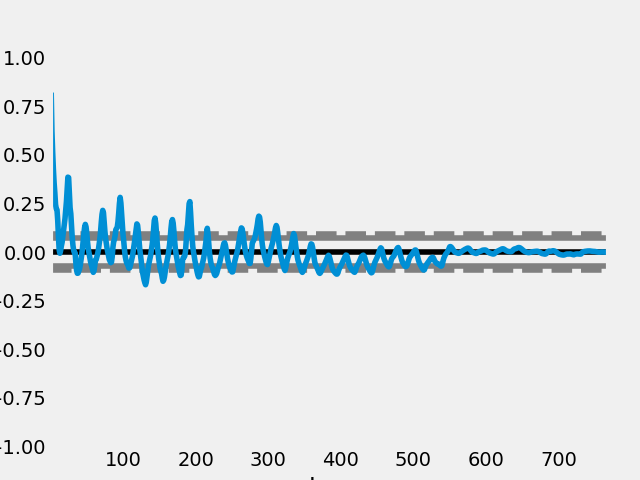

<IPython.core.display.Javascript object>


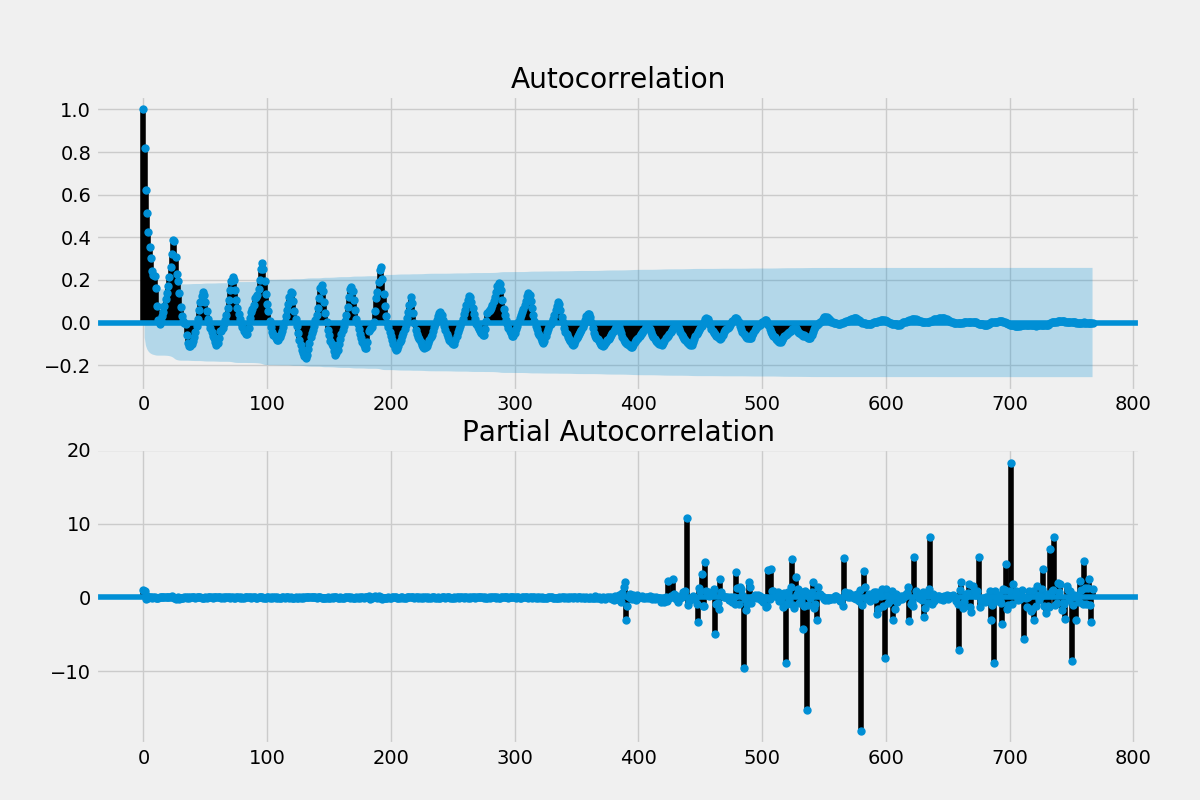

/home/joni/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning:

invalid value encountered in sqrt



In [4]:
df = fi_df['2018-01-01' : '2018-02-01']
plt.figure()
autocor = autocorrelation_plot(df['FI'].values)
plt.show()
#fig = go.Figure(data=[autocor])
#py.iplot(fig)
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['FI'].values, ax=ax1,  title="Autocorrelation")
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['FI'].values, ax=ax2, title="Partial Autocorrelation")
plt.show()

# SARIMA
Automatic configuration of p, d, and q values with pyramid

In [26]:
y = fi_df['2018-01-01':'2018-12-31']
arima = auto_arima(y, start_p=1, start_q=1,
                           max_p=13, max_q=13, max_d=10, m=7,
                           max_P=2, max_Q=2, max_D=2,
                           start_P=0, seasonal=True, stationary=True,
                           trace=True, max_order=35, maxiter=100,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

print("Paras aic: ",arima.aic())
print("Paras bic: ",arima.bic())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 7); AIC=57358.572, BIC=57393.962, Fit time=3.778 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 7); AIC=72459.236, BIC=72473.391, Fit time=0.145 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 7); AIC=57776.975, BIC=57805.287, Fit time=3.701 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 7); AIC=64064.911, BIC=64093.223, Fit time=3.196 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 1, 7); AIC=57359.886, BIC=57402.354, Fit time=12.268 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 7); AIC=57371.898, BIC=57400.210, Fit time=1.520 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 2, 7); AIC=57359.330, BIC=57401.797, Fit time=7.440 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 2, 7); AIC=57360.404, BIC=57409.949, Fit time=13.260 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 1, 7); AIC=57299.166, BIC=57341.633, Fit time=5.874 seconds
Fit ARIMA: order=

1kk: order=(1, 0, 2) seasonal_order=(0, 0, 1, 7)
1 vuosi: order=(4, 0, 2) seasonal_order=(2, 0, 2, 7)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9891      0.001    990.031      0.000       0.987       0.991
ma.L1          0.1810      0.002     79.117      0.000       0.176       0.185
ma.L2          0.0075      0.003      2.860      0.004       0.002       0.013
ma.S.L7       -0.0763      0.004    -18.226      0.000      -0.084      -0.068
sigma2        43.3753      0.079    547.600      0.000      43.220      43.531


<IPython.core.display.Javascript object>


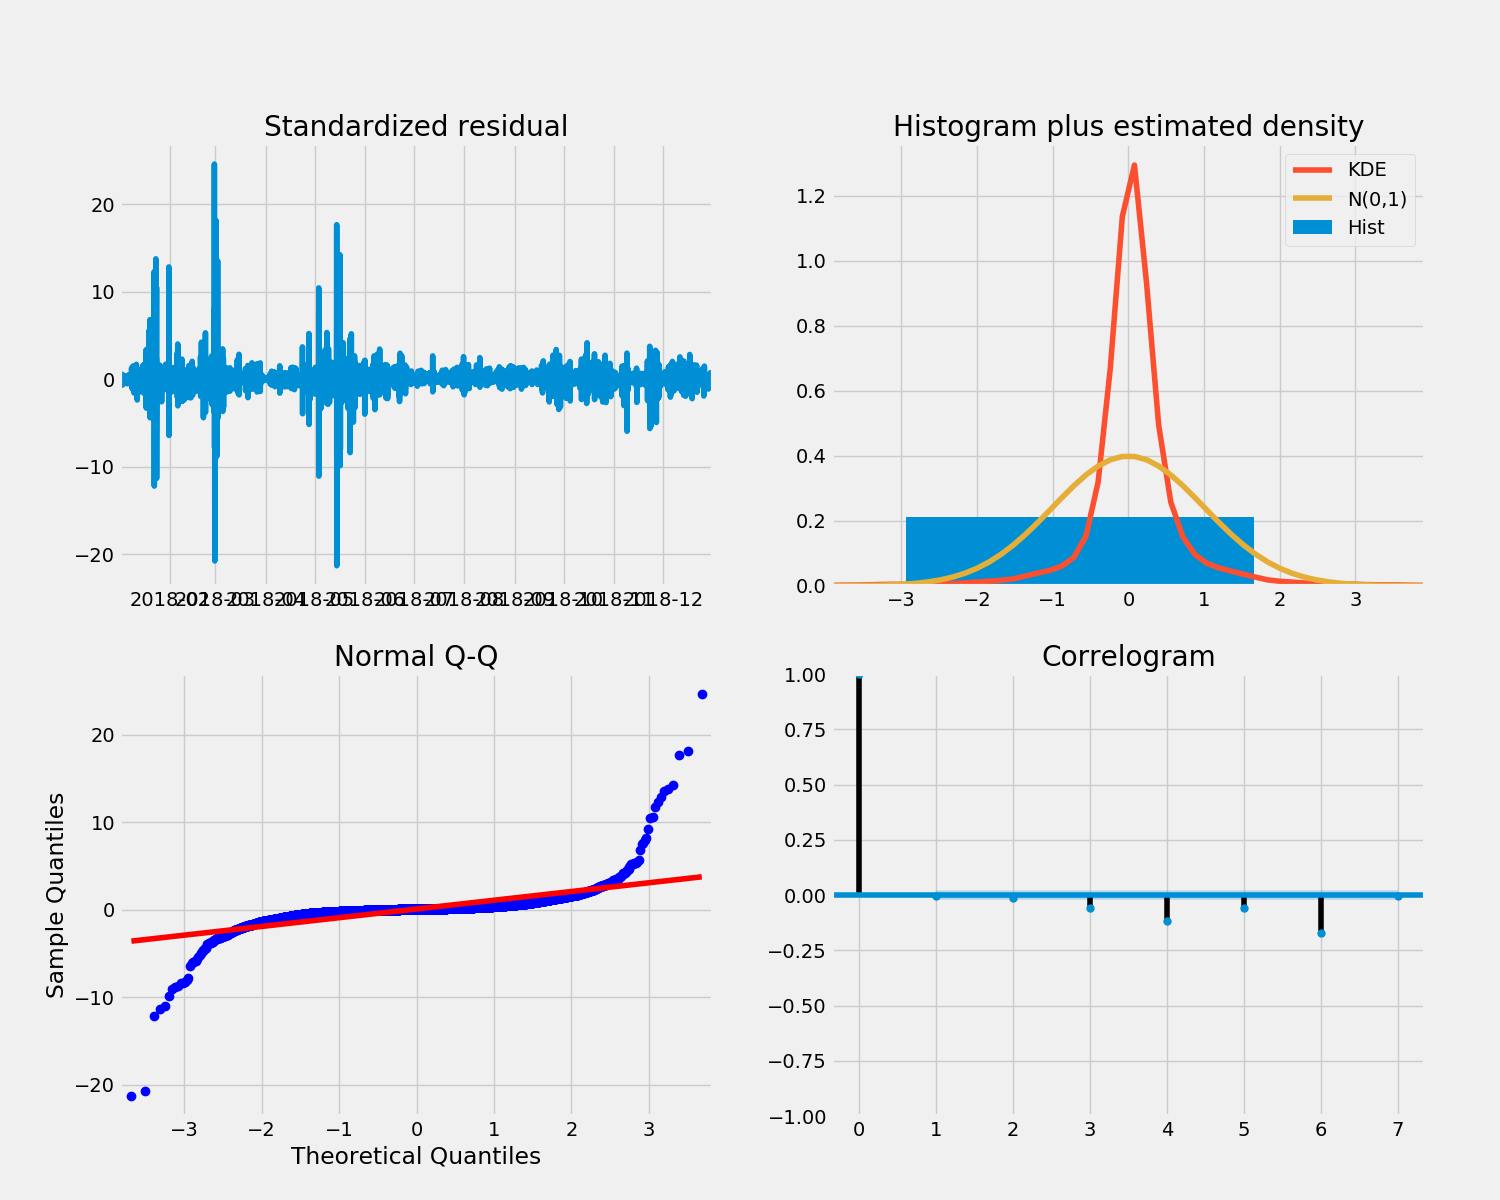

<IPython.core.display.Javascript object>


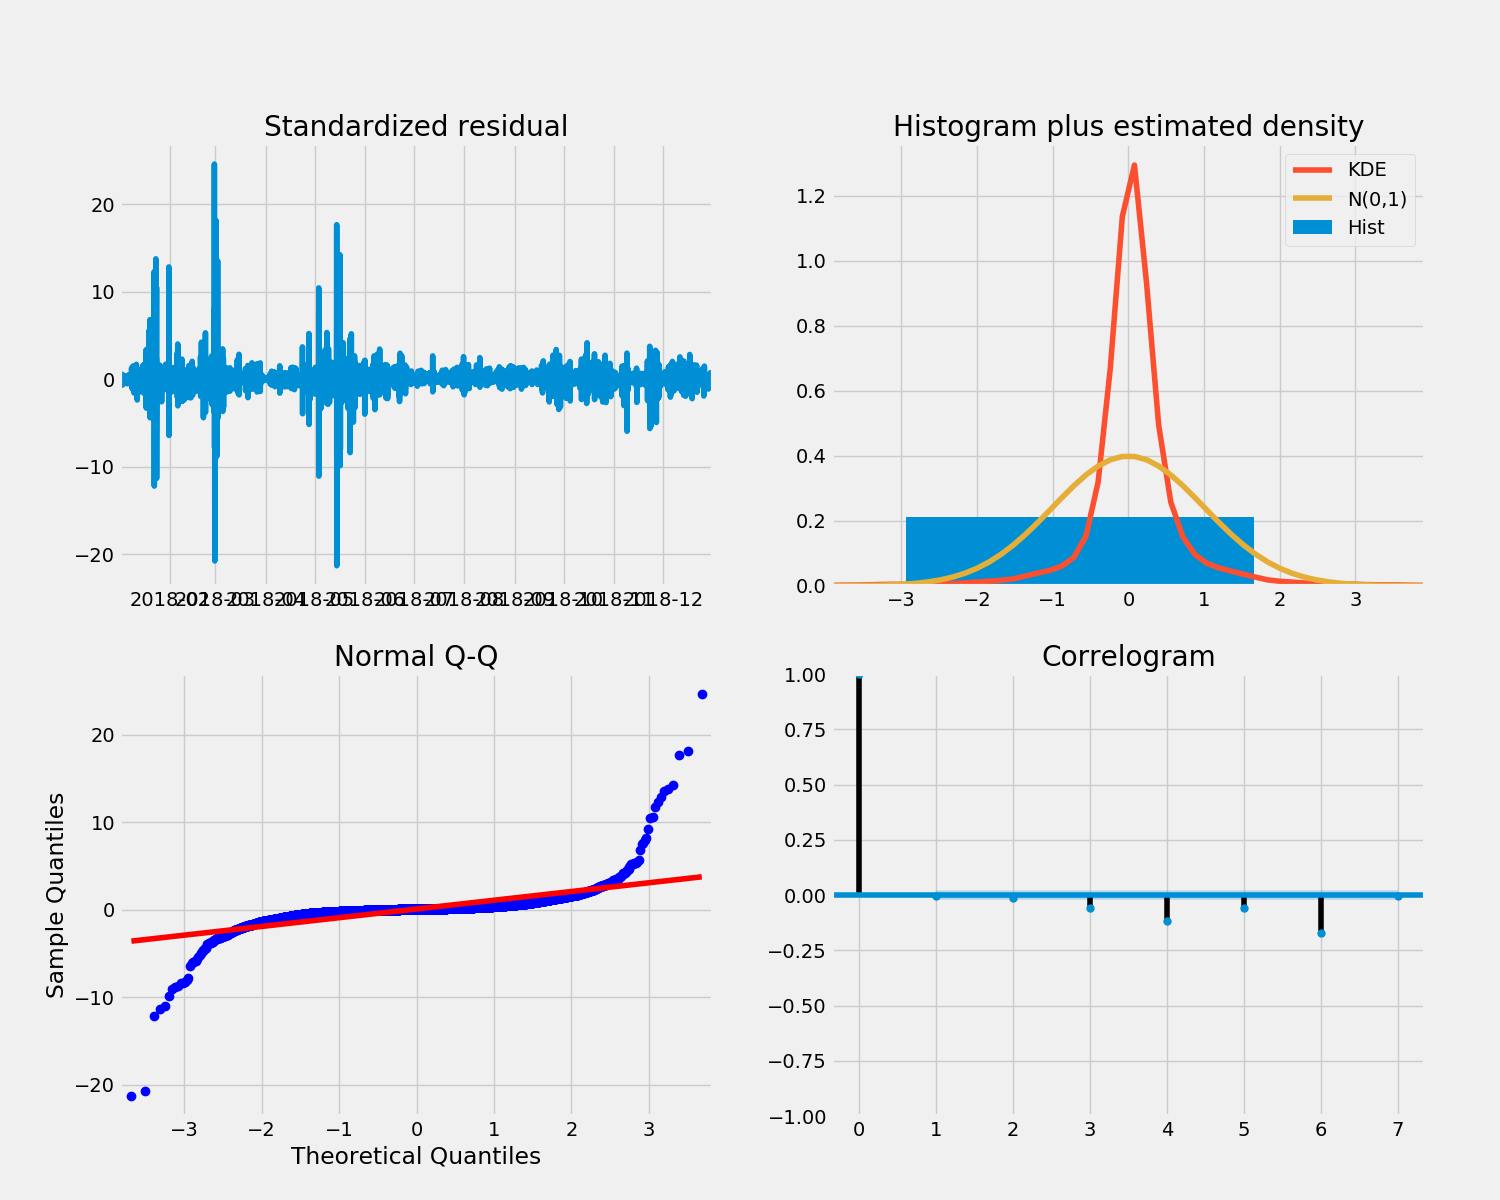

In [33]:
y.index = y.index.tz_localize(None)
mod = sm.tsa.statespace.SARIMAX(endog=y,
                                order=(1,0,2),
                                seasonal_order=(0,0,1,7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    results = mod.fit()
    print(results.summary().tables[1])
results.plot_diagnostics(figsize=(15, 12), lags=7)
#plt.show()

/home/joni/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning:

Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.



<IPython.core.display.Javascript object>


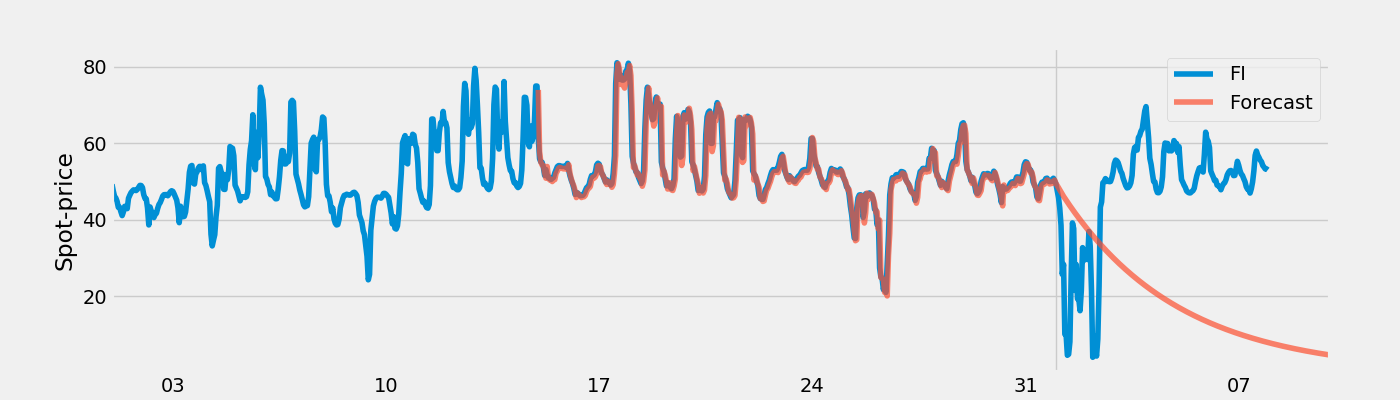

In [34]:
pred = results.get_prediction(start='2018-12-15',end='2019-01-10', dynamic=False)
fi_df.index = fi_df.index.tz_localize(None)
#fi_df.index
ax = fi_df['2018-12-01':'2019-01-07'].plot(label='Real', figsize=(14,4))
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)
ax.set_xlabel('Date')
ax.set_ylabel('Spot-price')
plt.legend()
plt.show()

# Energy consumption per sector

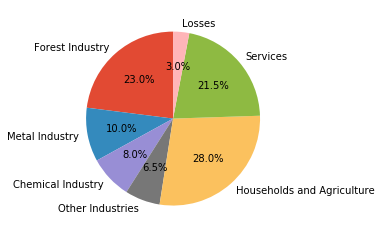

In [67]:
plt.style.use('ggplot')
indexes = ['Forest Industry','Metal Industry','Chemical Industry','Other Industries','Households and Agriculture','Services','Losses']
values = [20105,8741,6993,5700,24475,18775,2622,87412]
df = pd.DataFrame({'Consumption':[20105,8741,6993,5700,24475,18775,2622]},index=indexes)
#ax = df.sort_values(by='GWh',ascending=False).plot(kind='barh',legend=False)
ax = df.plot(kind='pie',y=['Consumption'],legend=False, autopct='%1.1f%%',startangle=90)
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

In [57]:
df

,Sector,Consumption
0,Forest Industry,20105
1,Metal Industry,8741
2,Chemical Industry,6993
3,Other Industries,5700
4,Households and Agriculture,24475
5,Services Consumption,18775
6,Losses,2622
7,Total Electricity Consumption,87412
